<a href="https://colab.research.google.com/drive/1KV29lvaNz9Qek_znPeHD3FPY1yl5vfh9?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from scipy import stats
import sklearn.linear_model as skl
from seaborn import heatmap
from sklearn.decomposition import PCA
import copy
from sklearn import svm

fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
fname = "resnet50_features.npy"
if not os.path.exists(fname):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ALYbVzD8Irznxx8BA65DnrcM09Tg5KgJ' -O resnet50_features.npy --quiet
fname = "resnet50_test_features.npy"
if not os.path.exists(fname):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1a1uwmP7oD7P_iHWmHRXKQq6o08b5DWpA' -O resnet50_test_features.npy --quiet

fname = "vgg16_features.npy"
if not os.path.exists(fname):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1epaylkWvcX0D-escbA9Yjj6WdJ3-SDcZ' -O vgg16_features.npy --quiet
fname = "vgg16_test_features.npy"
if not os.path.exists(fname):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1WrY7hmGtVQRPcefUwCJUf1NyosG-EfMy' -O vgg16_test_features.npy --quiet

fname = "vgg16_convfeatures.npy"
if not os.path.exists(fname):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=10r8jd5ql6e1HxuO-y_w7cbya7MJohtcF' -O vgg16_convfeatures.npy --quiet
fname = "vgg16_test_convfeatures.npy"
if not os.path.exists(fname):
  !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_lbObrQt733e03yHAF3pADfsj6PuCLQ2' -O vgg16_test_convfeatures.npy --quiet

In [ ]:
dataset = input('please enter the dataset you want to read : ')

if dataset == 'r':

  X_train = dat['responses']
  X_test = dat['responses_test']
  y_train = np.load('/content/resnet50_features.npy') 
  y_test = np.load('/content/resnet50_test_features.npy') 

  feats = 'Resnet50'

elif dataset == 'v':

  X_train = dat['responses']
  X_test = dat['responses_test']
  y_train = np.load('/content/vgg16_features.npy') 
  y_test = np.load('/content/vgg16_test_features.npy') 

  feats = 'VGG16'

elif dataset == 'vc':

  X_train = dat['responses']
  X_test = dat['responses_test']
  y_train = np.load('/content/vgg16_convfeatures.npy', allow_pickle=True) 
  y_test = np.load('/content/vgg16_test_convfeatures.npy', allow_pickle=True) 

  feats = 'VGG16 Convolution Layer'
  
print(feats, 'selected:')
print('\t X_train.shape: {} '.format(X_train.shape))
print('\t y_train.shape: ', y_train.shape)
print('\t X_test.shape:  ', X_test.shape)
print('\t y_test.shape:  ', y_test.shape)

print('Test set statistics:')
print('\t Mean:\t', np.mean(y_test))
print('\t Std:\t', np.std(y_test))
print('\t Range:\t', np.max(y_test)-np.min(y_test))

VGG16 selected:
	 X_train.shape:  (1750, 8428)
	 y_train.shape:  (1750, 4096)
	 X_test.shape:   (120, 8428)
	 y_test.shape:   (120, 4096)
Test set statistics:
	 Mean:	 0.18907653
	 Std:	 0.3137314
	 Range:	 3.2452157


In [ ]:
idx = np.arange(X_test.shape[1])

X_new_train = np.empty(shape=(1750,0))
X_new_test  = np.empty(shape=(120,0))

new_rois = np.empty(shape=(0,))

for roi in range(np.max(dat['roi'])+1):
  if roi != 0:
    indices = np.random.choice(idx[ dat['roi']==roi ].astype(int), 314)

    X_new_train = np.hstack((X_new_train, X_train[:, indices])) 
    X_new_test = np.hstack((X_new_test, X_test[:, indices]))

    new_rois = np.append(new_rois, roi * np.ones_like(indices))

print(feats, 'selected:')
print('\t X_new_train.shape: ', X_new_train.shape)
print('\t y_train.shape: ', y_train.shape)
print('\t X_new_test.shape:  ', X_new_test.shape)
print('\t y_test.shape:  ', y_test.shape)

VGG16 selected:
	 X_new_train.shape:  (1750, 2198)
	 y_train.shape:  (1750, 4096)
	 X_new_test.shape:   (120, 2198)
	 y_test.shape:   (120, 4096)


Fitting GLM to VGG16 with Ridge...
	 6 alphas remaining
	 5 alphas remaining
	 4 alphas remaining
	 3 alphas remaining
	 2 alphas remaining
	 1 alphas remaining


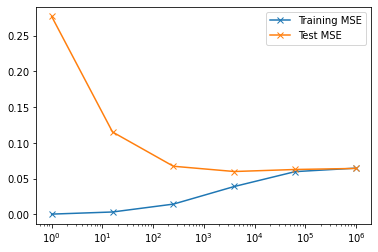

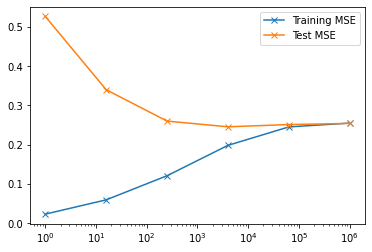

In [ ]:
print('Fitting GLM to', feats, 'with Ridge...')

num = 6

alphas = np.logspace(0,6,num=num)

mse_train_vec = np.zeros_like(alphas)
mse_test_vec = np.zeros_like(alphas)

models_vec = []

progress = num

for a in alphas:
  print('\t', progress, 'alphas remaining')

  model = skl.Ridge(alpha=a)

  model.fit(X_new_train, y_train)

  y_hat_Train = model.predict(X_new_train)
  mse_train = np.mean((y_train-y_hat_Train)**2)
  mse_train_vec[a == alphas] = mse_train

  y_hat_Test = model.predict(X_new_test)
  mse_test = np.mean((y_test-y_hat_Test)**2)
  mse_test_vec[a == alphas] = mse_test
  
  models_vec.append(model)

  progress -= 1

plt.figure()
plt.plot(alphas, mse_train_vec, 'x-', label='Training MSE')
plt.plot(alphas, mse_test_vec, 'x-', label='Test MSE')
plt.xscale('log')
plt.legend()
# plt.yscale('log')

plt.figure()
plt.plot(alphas, np.sqrt(mse_train_vec), 'x-', label='Training MSE')
plt.plot(alphas, np.sqrt(mse_test_vec), 'x-', label='Test MSE')
plt.xscale('log')
plt.legend()
# plt.yscale('log')

In [ ]:
model = models_vec[np.argmin(np.abs(mse_test_vec - mse_train_vec))]

print('Model selected with alpha =', alphas[np.argmin(np.abs(mse_test_vec - mse_train_vec))])

runs = 10

progress = np.abs(runs)

mse_vec_tot = np.zeros(shape=(runs, len(dat['roi_names'])))

for k in range(runs):

  print('\t', progress, 'more runs...')

  mse_vec = []

  test_indices = np.random.choice(np.vstack((y_train, y_test)).shape[0], 120)

  X_test_loop = np.vstack((X_new_train, X_new_test))[test_indices,:]
  y_test_loop = np.vstack((y_train, y_test))[test_indices,:]

  for idx in range(1,np.max(new_rois).astype(int)+1):
    X_test_cancelled = copy.deepcopy(X_test_loop)
    X_test_cancelled[:, new_rois==idx] = 0

    y_hat_Test_cancelled = model.predict(X_test_cancelled)

    mse = np.mean((y_test_loop-y_hat_Test_cancelled)**2)

    mse_vec.append(mse)
    # print('Test set MSE with ROI', idx, 'called', dat['roi_names'][idx], '(with', len(dat['roi'][dat['roi'] == idx]), 'voxels) cancelled out: \t', mse)
    mse_vec_tot[k, idx] = mse

  progress -= 1

Model selected with alpha = 1000000.0
	 10 more runs...
	 9 more runs...
	 8 more runs...
	 7 more runs...
	 6 more runs...
	 5 more runs...
	 4 more runs...
	 3 more runs...
	 2 more runs...
	 1 more runs...


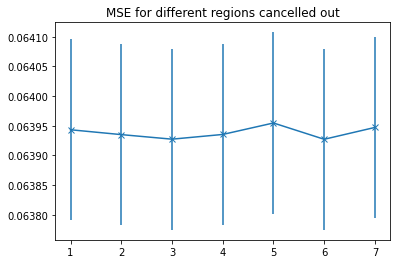

In [ ]:
# plt.boxplot(mse_vec_tot[:,1:])
plt.errorbar(range(1,8), mse_vec_tot.mean(0)[1:], yerr=mse_vec_tot.std(0)[1:]/10, fmt='x-')
# plt.hlines(mse_vec_tot.mean(0)[0], xmin=0, xmax=7, linestyles='dashed', alpha=0.5)
t = plt.title('MSE for different regions cancelled out')